In [1]:
# Loading in the Libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gamma

# Allows for the hot reloading of modules
%load_ext autoreload
%autoreload 2

# Loading in the Simulation Objects
from src.Centrifugation import *
from src.DataLoader import load_data_from_txt, normalize_data

In [53]:
# Centrifugation parms
time = 10 # (min)
rpm = 4000
arm_length = 10 * 1e-2 # length of centrifuge 10cm  (m)
length = 1 * 1e-2 # tube length 1cm (m)

# Liquid parms
liquid_density = 997 # water (kg/m^2)
liquid_viscosity = 1 # water (mPa.s)

# Particle parms
particle_density = 2330 # silicon (kg.m^2)

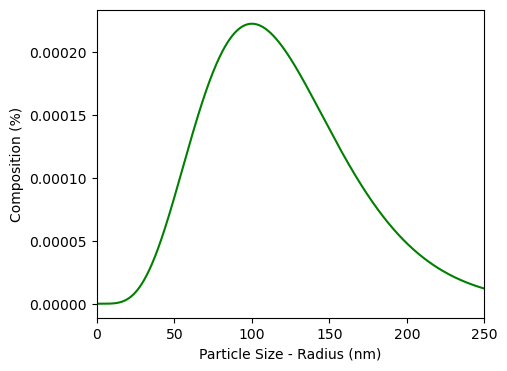

In [107]:
# Inital size distribution - uniformed distribution
count = 10000
size = np.linspace(1,251,count) * 1e-9

shape_param = 6.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

probability = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability /= np.sum(probability)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(size*1e9, probability, color='Green')

ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Size - Radius (nm)")
ax.set_ylabel("Composition (%)")

plt.show(fig)

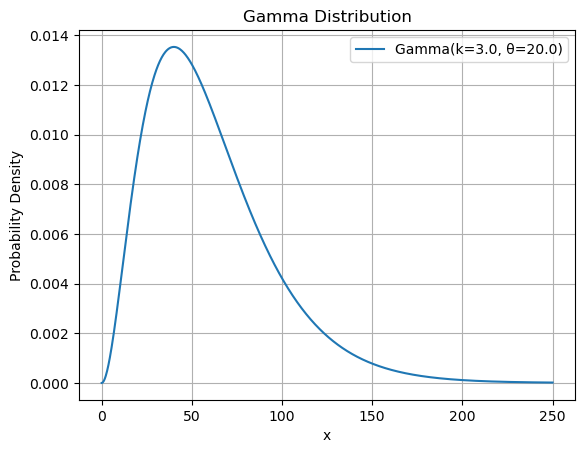

In [87]:
# Parameters for the gamma distribution
shape_param = 3.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

# Generate x values
x = np.linspace(0, 250, 1000)

# Calculate the gamma distribution probability density function (PDF)
y = gamma.pdf(x, shape_param, scale=scale_param)

# Plot the distribution
plt.plot(x, y, label=f'Gamma(k={shape_param}, θ={scale_param})')
plt.title('Gamma Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

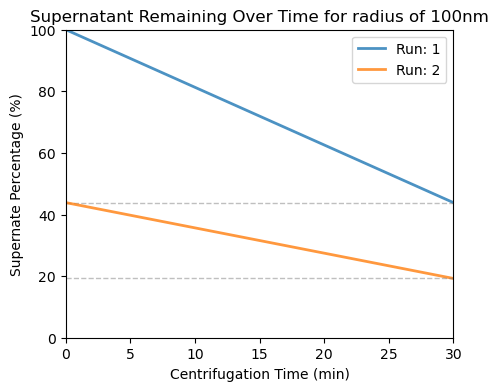

In [47]:
# How does mutiple runs look for a single size particle?
size = 100 * 1e-9
rpm = 4000
runs = 2 

prob = 1

fig, ax = plt.subplots(figsize=(5,4))
for run in range(runs):
    time = np.linspace(0,30,100)
    prob_remaining = cal_remaining_percent(size, prob, time,
                                            particle_density, liquid_density, liquid_viscosity,
                                            rpm, arm_length, length)
    prob = prob_remaining[-1]
    ax.plot(time, prob_remaining * 1e2, label=f"Run: {run +1}", alpha = 0.8, linewidth=2) 

    # Add a gray dotted line at y=prob
    ax.axhline(y=prob * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Supernatant Remaining Over Time for radius of {size * 1e9:.0f}nm')
ax.legend()


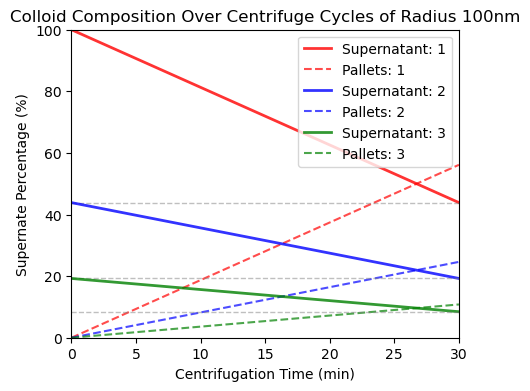

In [49]:
# Pallets and supernatants
size = 100 * 1e-9
rpm = 4000
runs = 3 

prob = 1

# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))
for run in range(runs):
    time = np.linspace(0,30,100)
    supernate, pallets = cal_supernate_and_pallets(size, prob, time,
                                            particle_density, liquid_density, liquid_viscosity,
                                            rpm, arm_length, length)
    prob = supernate[-1]
    ax.plot(time, supernate * 1e2, label=f"Supernatant: {run +1}", alpha = 0.8, linewidth=2, color=colors[run]) 
    ax.plot(time, pallets * 1e2, label=f"Pallets: {run + 1}", alpha=0.7, linestyle='--', color=colors[run])

    # Add a gray dotted line at y=prob
    ax.axhline(y=prob * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Colloid Composition Over Centrifuge Cycles of Radius {size * 1e9:.0f}nm')
ax.legend()


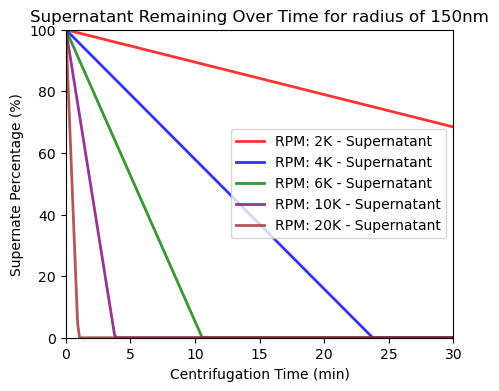

In [44]:
# How does speed effect the change over time
count = 1000
size = 150 * 1e-9
rpm = np.array([2000, 4000, 6000, 10000, 20000])
j = 0

fig, ax = plt.subplots(figsize=(5,4))

colors = ['red', 'blue', 'green', 'purple', 'brown']

for speed in rpm:
    prob = 1
    time = np.linspace(0,30,200)
    prob, pallets = cal_supernate_and_pallets(size, prob, time,
                                          particle_density, liquid_density, liquid_viscosity,
                                         speed, arm_length, length)
    
    
#     ax.plot(time, remaining_percent * 1e2, label=f"RPM: {speed * 1e-3:.0f}K", alpha = 0.8, linewidth=2)
    ax.plot(time, prob * 1e2, label=f"RPM: {speed * 1e-3:.0f}K - Supernatant", alpha = 0.8, linewidth=2, color=colors[j]) 
#     ax.plot(time, pallets * 1e2, label=f"RPM: {speed * 1e-3:.0f}K - Pallets", alpha=0.7, linestyle='--', color=colors[j])
    j += 1
    

ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Supernatant Remaining Over Time for radius of {size * 1e9:.0f}nm')
ax.legend()


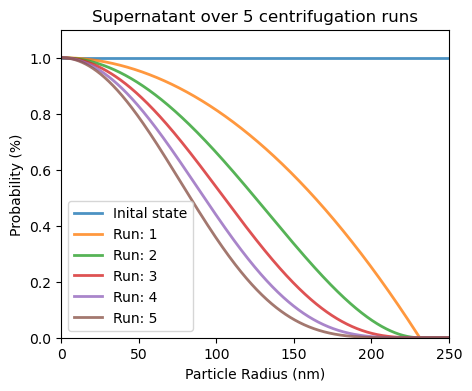

In [51]:
# How does the distribution of the particles over multiple runs change.
runs = 5
count = 1000
size = np.linspace(1,251,count) * 1e-9
rpm = 4000

prob = np.ones(count)
times = 10


fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob, label=f"Inital state", alpha = 0.8, linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
    ax.plot(size*1e9, prob, label=f"Run: {j+ 1}", alpha = 0.8, linewidth=2)

    
ax.set_xlim([0,250])
ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"Supernatant over {runs} centrifugation runs")
ax.legend()


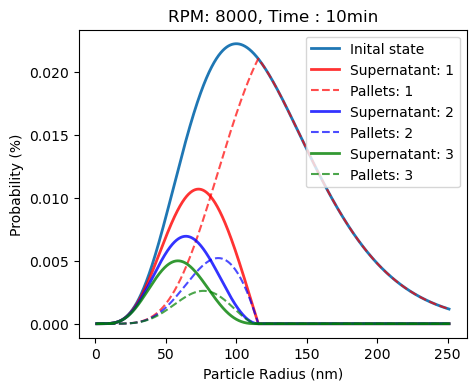

In [108]:
# How does the distribution supernate and pallets of the particles over multiple runs change.
runs = 3
# count = 1000
# size = np.linspace(1,251,count) * 1e-9

# Inital size distribution - uniformed distribution
count = 10000
size = np.linspace(1,251,count) * 1e-9

shape_param = 6.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

probability = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability /= np.sum(probability)
rpm = 8000

prob = probability
pallets = np.zeros(count)
times = 10


# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob * 1e2, label=f"Inital state", linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets[i] = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
        
    ax.plot(size*1e9, prob * 1e2, label=f"Supernatant: {j +1}", alpha = 0.8, linewidth=2, color=colors[j]) 
    ax.plot(size*1e9, pallets * 1e2, label=f"Pallets: {j + 1}", alpha=0.7, linestyle='--', color=colors[j])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"RPM: {rpm}, Time : {times}min")
ax.legend()


In [14]:
# how does the experimental data look?
data = load_data_from_txt('/Users/william/Developer/Nano-Particle-Playground/data/Centrifugation/Week 5 - Data/concentrations - week 5.txt')
data.columns

Index(['Radii(nm)', 'Raw', '1kp', '2kp', '4kp', '8kp', '8ks'], dtype='object')

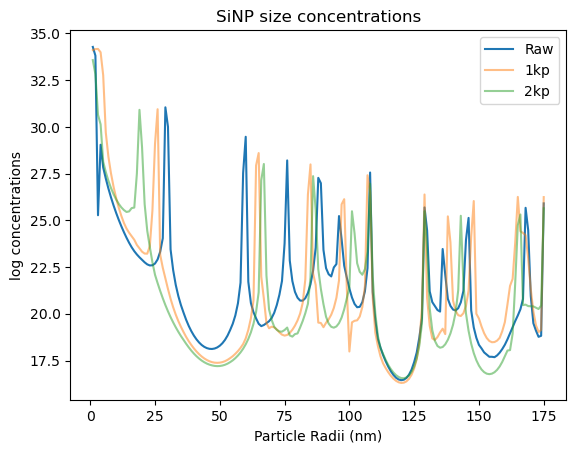

In [9]:
mask = data['Radii(nm)'] > 0
plt.plot(data['Radii(nm)'][mask], np.log(data['Raw'][mask]), label='Raw', alpha = 1)
plt.plot(data['Radii(nm)'][mask], np.log(data['1kp'][mask]), label='1kp', alpha = 0.5)
plt.plot(data['Radii(nm)'][mask], np.log(data['2kp'][mask]), label='2kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['4kp'][mask]), label='4kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8kp'][mask]), label='8kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8ks'][mask]), label='8ks', alpha = 0.5)

plt.title("SiNP size concentrations")
plt.ylabel("log concentrations")
plt.xlabel("Particle Radii (nm)")
plt.legend()

### Questions about the data...
*What are the units for the recorded concentration?*

*What is the duration of the centrifugation events?*
- I am going to assume that centrifugation was on a 10 min duration

*Is each recording from the samme Raw sample?*

*Is 2kp initally taken from Raw or 1kp?*
- Assuming that Raw is the inital state for each of the centrifugation runs --> meaning that each recording is operated in a single centrifugation cycle

In [15]:
# normalsing the concentration
data = normalize_data(data)
data

,Radii(nm),Raw,1kp,2kp,4kp,8kp,8ks,Raw_norm,1kp_norm,2kp_norm,4kp_norm,8kp_norm,8ks_norm
0,1.0,7.685676e+14,6.483145e+14,3.798114e+14,1.518078e+14,2.865572e+14,2.781941e+14,1.000000e+00,9.391830e-01,1.000000,1.000000e+00,1.000000,1.000000e+00
1,2.0,4.817059e+14,6.839448e+14,1.784217e+14,3.944614e+12,2.005333e+14,2.300023e+13,6.267580e-01,9.907990e-01,0.469764,2.598426e-02,0.699802,8.267691e-02
2,3.0,9.442403e+10,6.902962e+14,2.038721e+13,6.167869e+10,8.443178e+13,4.811114e+11,1.228391e-04,1.000000e+00,0.053677,4.062896e-04,0.294642,1.729400e-03
3,4.0,4.101071e+12,5.776151e+14,1.221806e+13,2.562836e+10,1.045829e+13,2.139849e+11,5.335975e-03,8.367641e-01,0.032169,1.688160e-04,0.036496,7.691838e-04
4,5.0,1.219889e+12,1.692603e+14,1.653221e+12,1.286898e+10,4.962216e+12,1.082024e+11,1.587206e-03,2.451995e-01,0.004353,8.476645e-05,0.017316,3.889364e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171.0,2.923032e+08,5.484072e+08,7.201171e+08,1.879710e+06,4.339638e+10,2.449949e+08,3.622354e-07,7.770553e-07,0.000002,7.307225e-09,0.000151,8.715479e-07
171,172.0,1.973226e+08,2.623644e+08,6.733855e+08,1.797007e+06,2.075196e+10,1.550361e+08,2.386542e-07,3.626784e-07,0.000002,6.762436e-09,0.000072,5.481812e-07
172,173.0,1.414667e+08,1.829645e+08,6.259766e+08,1.413597e+06,1.268511e+09,9.916970e+07,1.659789e-07,2.476554e-07,0.000002,4.236808e-09,0.000004,3.473630e-07
173,174.0,1.493765e+08,2.038264e+08,7.539985e+08,1.037768e+06,1.036834e+09,1.260301e+08,1.762705e-07,2.778771e-07,0.000002,1.761120e-09,0.000003,4.439159e-07


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


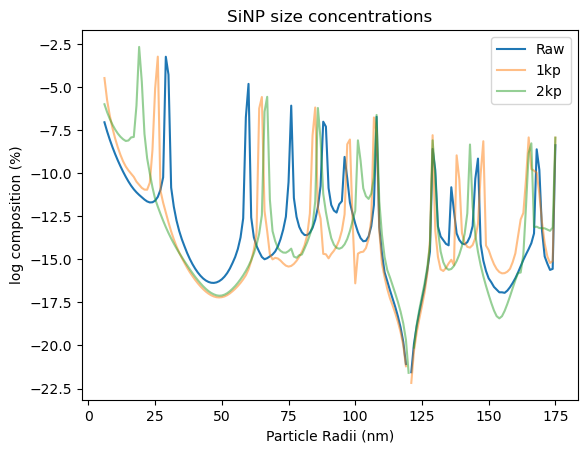

In [16]:
mask = data['Radii(nm)'] > 5
plt.plot(data['Radii(nm)'][mask], np.log(data['Raw_norm'][mask]), label='Raw', alpha = 1)
plt.plot(data['Radii(nm)'][mask], np.log(data['1kp_norm'][mask]), label='1kp', alpha = 0.5)
plt.plot(data['Radii(nm)'][mask], np.log(data['2kp_norm'][mask]), label='2kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['4kp'][mask]), label='4kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8kp'][mask]), label='8kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8ks'][mask]), label='8ks', alpha = 0.5)

plt.title("SiNP size concentrations")
plt.ylabel("log composition (%)")
plt.xlabel("Particle Radii (nm)")
plt.legend()

In [ ]:
# How does the distribution of the particles over multiple runs change.
runs = 1
size = data['Radii(nm)']
rpm = 1000
prob = data['1kp_norm']
times = 10 # duration of centrifugation


fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob, label=f"Inital state", alpha = 0.8, linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
    ax.plot(size*1e9, prob, label=f"Run: {j+ 1}", alpha = 0.8, linewidth=2)

    
ax.set_xlim([0,250])
ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"Supernatant over {runs} centrifugation runs")
ax.legend()